# Likelihood contourf with heavy nonminimal model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

from Likelihood import LEff
from mcmc_utils import labels_fancy
from dark_nus_utils import load_datasets
from const import alphaQED
from parameters_dict import tpc_systematic_uncertainties

In [3]:
hierarchy = 'heavy'
D_or_M = 'majorana'
distance = 'log'
smoothing_pars = (0.1, 0.1)

selection = 'cut_based'

spec = 'non_minimal'

save_folder = f'../fig/6_limit_visualisation/{hierarchy}_{D_or_M}_{spec}/'
!mkdir -p $save_folder

In [4]:
levels = {0.68: -2.3/2,
          0.9: -4.61/2,
          0.95: -5.99/2}

In [ ]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=False,
                                load_grid=False)

heavy majorana FHC
loading df base
initialising df base


In [ ]:
from ctau_utils import ctau_heavy
def heavy_nonminimal_posterior(my_exp_analyses, fluxes=['FHC', 'RHC'], 
                               hierarchy='heavy', D_or_M='majorana',
                               m4=0.1, mz=1.25, Umu4_2=2.2e-7, Ud4_2=0.01, alpha_d=0.4, epsilon=2.1e-2,
                               selection_query='cut_based',
                               systs=tpc_systematic_uncertainties, 
                               additional_efficiency=0.1,
                               ctau_mode='expo'):
    Vmu4_alpha_epsilon2 = alpha_d * Umu4_2 * alphaQED * epsilon**2
    Valpha4_alpha_epsilon2 = alpha_d * Ud4_2 * alphaQED * epsilon**2
    ctau = ctau_heavy(m4, 
                      mz, 
                      Valpha4_alpha_epsilon2, 
                      D_or_M)
    
    leff, mu, sigma2, N_ctau, N_final = 0, 0, 0, 0, 0
    for flux in fluxes:
        my_exp_analysis = my_exp_analyses[f'{hierarchy}_{D_or_M}_{flux}']
        this_mu = Vmu4_alpha_epsilon2/my_exp_analysis.Vmu4_alpha_epsilon2 * additional_efficiency
        syst = systs[flux]
        aux_mu, aux_sigma2, aux_N_ctau, aux_N_final = my_exp_analysis.kde_n_events_new(df=my_exp_analysis,
                                                                                     selection_query=selection_query,
                                                                                     m4mz=(m4, mz),
                                                                                     ctau=ctau,
                                                                                     mu=this_mu,
                                                                                     distance=distance,
                                                                                     smoothing=smoothing_pars,
                                                                                     provide_n_samples=True)
        leff += LEff(0, aux_mu, aux_sigma2 + (syst*aux_mu)**2)
        mu += aux_mu
        sigma2 += (aux_sigma2 + (syst*aux_mu)**2) 
        N_ctau += aux_N_ctau
        N_final += aux_N_final
    return leff, mu, sigma2, ctau, N_ctau, N_final

heavy_nonminimal_posterior_v = np.vectorize(heavy_nonminimal_posterior, excluded=['my_exp_analyses', 'fluxes', 'hierarchy', 'D_or_M',
                                                                                  'method', 'systs', 'additional_efficiency', 'selection_query',
                                                                                 'ctau_mode'])

## Varying $|U_{D4}|^2$

In [20]:
# setting
m4 = np.geomspace(my_exp_analyses[f'{hierarchy}_{D_or_M}_FHC'].m4_limits[0],
                  my_exp_analyses[f'{hierarchy}_{D_or_M}_FHC'].m4_limits[1],
                  30)
Umu4_2 = np.geomspace(1e-11,
                      1e-6,
                      30)
m4, Umu4_2 = np.meshgrid(m4, Umu4_2)

hnl_Ud4_2_s = [1]

In [21]:
# calculation
hnl_constraints = {}
for Ud4_2 in hnl_Ud4_2_s:
    hnl_constraints[Ud4_2] = heavy_nonminimal_posterior_v(my_exp_analyses, m4=m4, Umu4_2=Umu4_2, Ud4_2=Ud4_2)

Text(0, 0.5, '$|U_{{\\mu 4}}|^2$')

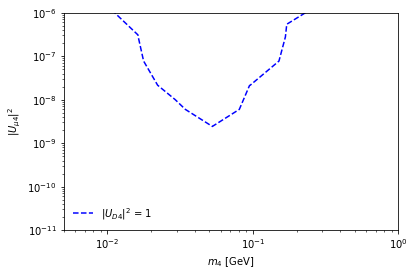

In [22]:
# plot
colors = ['blue', 'orange', 'green']
contours = {}
for Ud4_2, color in zip(hnl_Ud4_2_s, colors):
    contours[Ud4_2] = plt.contour(m4, Umu4_2, hnl_constraints[Ud4_2][0], levels=[levels[0.9]], colors=[color])
plt.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
           [f'$|U_{{D4}}|^2$ = {Ud4_2}' for Ud4_2 in contours.keys()],
           frameon=False,
           loc='lower left')
plt.loglog()
plt.xlabel(r'$m_4$ [GeV]')
plt.ylabel(r'$|U_{{\mu 4}}|^2$')

## Dark photon plots

In [ ]:
# setting
# mz = np.geomspace(0.11, my_exp_analyses[f'{hierarchy}_{D_or_M}_FHC'].mz_limits[1], 25)
# epsilon = np.geomspace(1e-6, 1e-1, 30)
mz = np.geomspace(0.11, 1, 5)
epsilon = np.geomspace(1e-3, 1e-1, 5)
mz, epsilon = np.meshgrid(mz, epsilon)

# dark_photons_Ud4_2_s = [1, 1e-2, 1e-4, 2.2e-7]
dark_photons_Ud4_2_s = [1]

In [ ]:
# calculation
dark_photons_constraints = {}
dark_photons_constraints_new = {}
for Ud4_2 in dark_photons_Ud4_2_s:
    dark_photons_constraints[Ud4_2] = heavy_nonminimal_posterior_v(my_exp_analyses, mz=mz, epsilon=epsilon, Ud4_2=Ud4_2, method='old')    
    dark_photons_constraints_new[Ud4_2] = heavy_nonminimal_posterior_v(my_exp_analyses, mz=mz, epsilon=epsilon, Ud4_2=Ud4_2, method='new')

In [ ]:
# plot
colors = ['blue', 'orange']
contours = {}
contours['old'] = plt.contour(mz, epsilon, dark_photons_constraints[Ud4_2][0], 
                                  levels=[levels[0.9]], colors=[colors[0]])
contours['new'] = plt.contour(mz, epsilon, dark_photons_constraints_new[Ud4_2][0], 
                                  levels=[levels[0.9]], colors=[colors[1]])
plt.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
           contours.keys(),
           frameon=False,
           loc='lower right')
plt.loglog()
plt.xlabel(r'$m_z$ [GeV]')
plt.ylabel(r'$\epsilon$')

Text(0, 0.5, '$\\epsilon$')

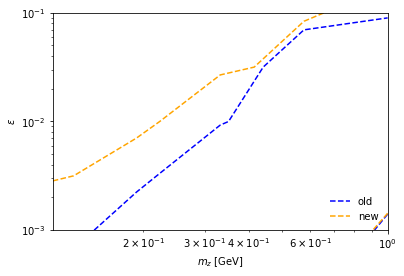

In [14]:
# plot
colors = ['blue', 'orange']
contours = {}
contours['old'] = plt.contour(mz, epsilon, dark_photons_constraints[Ud4_2][0], 
                                  levels=[levels[0.9]], colors=[colors[0]])
contours['new'] = plt.contour(mz, epsilon, dark_photons_constraints_new[Ud4_2][0], 
                                  levels=[levels[0.9]], colors=[colors[1]])
plt.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
           contours.keys(),
           frameon=False,
           loc='lower right')
plt.loglog()
plt.xlabel(r'$m_z$ [GeV]')
plt.ylabel(r'$\epsilon$')

Text(0, 0.5, '$\\epsilon$')

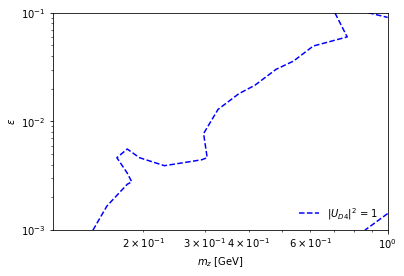

In [11]:
# plot
colors = ['blue', 'orange', 'green', 'purple']
contours = {}
for Ud4_2, color in zip(dark_photons_Ud4_2_s, colors):
    contours[Ud4_2] = plt.contour(mz, epsilon, dark_photons_constraints[Ud4_2][0], 
                                  levels=[levels[0.9]], colors=[color])
plt.legend([cntr.legend_elements()[0][0] for cntr in contours.values()], 
           [f'$|U_{{D4}}|^2$ = {Ud4_2}' if Ud4_2!=2.2e-7 else f'$|U_{{D4}}|^2 = |U_{{\mu4}}|^2$' for Ud4_2 in contours.keys()],
           frameon=False,
           loc='lower right')
plt.loglog()
plt.xlabel(r'$m_z$ [GeV]')
plt.ylabel(r'$\epsilon$')

Text(0, 0.5, '$\\epsilon$')

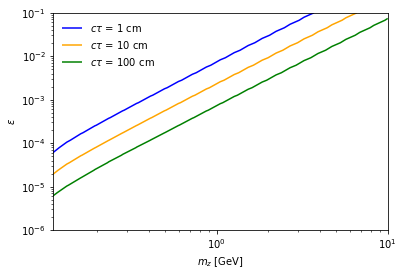

In [38]:
# plot
lifetimes = [1, 10, 100]
colors = ['blue', 'orange', 'green']
contour = plt.contour(mz, epsilon, dark_photons_constraints[1][3], levels=lifetimes, colors=colors)
plt.legend(contour.legend_elements()[0], 
           [f'$c \\tau$ = {lifetime} cm' for lifetime in lifetimes],
           frameon=False,
           loc='upper left')
plt.loglog()
plt.xlabel(r'$m_z$ [GeV]')
plt.ylabel(r'$\epsilon$')

Text(0, 0.5, '$\\epsilon$')

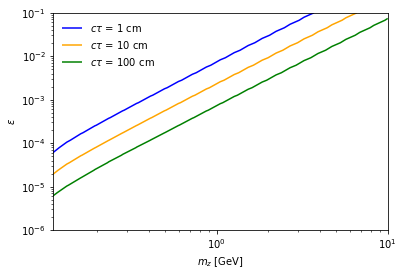

In [39]:
# plot
lifetimes = [1, 10, 100]
colors = ['blue', 'orange', 'green']
contour = plt.contour(mz, epsilon, dark_photons_constraints_new[1][3], levels=lifetimes, colors=colors)
plt.legend(contour.legend_elements()[0], 
           [f'$c \\tau$ = {lifetime} cm' for lifetime in lifetimes],
           frameon=False,
           loc='upper left')
plt.loglog()
plt.xlabel(r'$m_z$ [GeV]')
plt.ylabel(r'$\epsilon$')

<ipython-input-40-acdde008661b>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = axs[0][0].pcolormesh(mz, epsilon, -dark_photons_constraints[Ud4_2][0], norm=LogNorm())
<ipython-input-40-acdde008661b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = axs[0][1].pcolormesh(mz, epsilon, dark_photons_constraints[Ud4_2][1], norm=LogNorm())
<ipython-input-40-acdde008661b>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimens

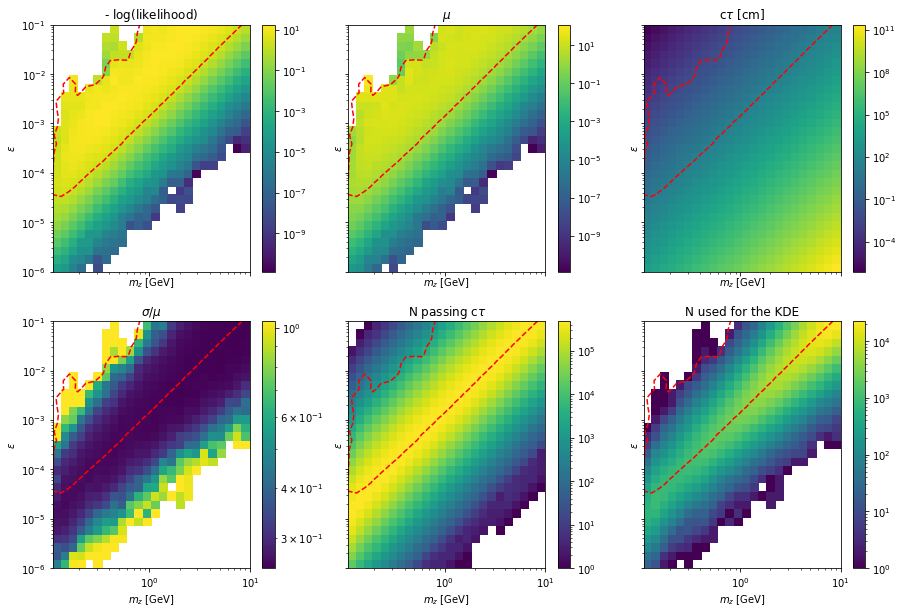

In [40]:
Ud4_2 = 1 
# this_dark_photons_constraints = dark_photons_constraints_expo[Ud4_2]
this_dark_photons_constraints = dark_photons_constraints_integral[Ud4_2]
# this_dark_photons_constraints = dark_photons_constraints_integral_last_layer_lead[Ud4_2]

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axs[0][0].loglog()

pcm = axs[0][0].pcolormesh(mz, epsilon, -this_dark_photons_constraints[0], shading='auto')
fig.colorbar(pcm, ax=axs[0][0])
axs[0][0].set_title(r'- $\log$(likelihood)')

pcm = axs[0][1].pcolormesh(mz, epsilon, this_dark_photons_constraints[1], shading='auto')
fig.colorbar(pcm, ax=axs[0][1])
axs[0][1].set_title(r'$\mu$')

pcm = axs[0][2].pcolormesh(mz, epsilon, this_dark_photons_constraints[5], norm=LogNorm(), shading='auto')
fig.colorbar(pcm, ax=axs[0][2])
axs[0][2].set_title(r'N used for the KDE')


pcm = axs[1][0].pcolormesh(mz, epsilon, np.sqrt(this_dark_photons_constraints[2])/this_dark_photons_constraints[1], 
                           norm=LogNorm(), shading='auto')
fig.colorbar(pcm, ax=axs[1][0])
axs[1][0].set_title(r'$\sigma / \mu$')

pcm = axs[1][1].pcolormesh(mz, epsilon, this_dark_photons_constraints[4], norm=LogNorm(), shading='auto')
fig.colorbar(pcm, ax=axs[1][1])
axs[1][1].set_title(r'N passing c$\tau$')

pcm = axs[1][2].pcolormesh(mz, epsilon, this_dark_photons_constraints[3], norm=LogNorm(), shading='auto')
fig.colorbar(pcm, ax=axs[1][2])
axs[1][2].set_title(r'c$\tau$ [cm]')

for axes in axs:
    for ax in axes:
        ax.set_xlabel(r'$m_z$ [GeV]')
        ax.set_ylabel(r'$\epsilon$')
        ax.contour(mz, epsilon, this_dark_photons_constraints[0], levels=[levels[0.9]], colors=['red'])
        
# fig.savefig(save_folder + 'dark_photon_space_study_precision.png', bbox_inches='tight', dpi=250)
# fig.savefig(save_folder + 'dark_photon_space_study_precision.pdf')

In [ ]:
Ud4_2 = 1 
# this_dark_photons_constraints = dark_photons_constraints_expo[Ud4_2]
# this_dark_photons_constraints = dark_photons_constraints_integral[Ud4_2]
# this_dark_photons_constraints = dark_photons_constraints_integral_last_layer_lead[Ud4_2]

fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

for i, (this_dark_photons_constraints, label) in enumerate(zip([dark_photons_constraints_expo, 
                                                  dark_photons_constraints_integral, 
                                                  dark_photons_constraints_integral_last_layer_lead],
                                                      ['expo', 'integral', 'last_layer_lead'])):
    
    this_dark_photons_constraints = this_dark_photons_constraints[Ud4_2]
    axs[i][0].loglog()

    pcm = axs[i][0].pcolormesh(mz, epsilon, -this_dark_photons_constraints[0], shading='auto')
    fig.colorbar(pcm, ax=axs[i][0])
    axs[i][0].set_title(r'- $\log$(likelihood)')

    pcm = axs[i][1].pcolormesh(mz, epsilon, this_dark_photons_constraints[1], shading='auto')
    fig.colorbar(pcm, ax=axs[i][1])
    axs[i][1].set_title(r'$\mu$ ' + label)

    pcm = axs[i][2].pcolormesh(mz, epsilon, this_dark_photons_constraints[5], norm=LogNorm(), shading='auto')
    fig.colorbar(pcm, ax=axs[i][2])
    axs[i][2].set_title(r'N used for the KDE')

    for ax in axs[i]:
        ax.set_xlabel(r'$m_z$ [GeV]')
        ax.set_ylabel(r'$\epsilon$')
        ax.contour(mz, epsilon, this_dark_photons_constraints[0], levels=[levels[0.9]], colors=['red'])
        
fig.savefig(save_folder + 'dark_photon_space_study_methods_comparison.png', bbox_inches='tight', dpi=250)
fig.savefig(save_folder + 'dark_photon_space_study_methods_comparison.pdf')